<h1><center>Making a Million Dollars with eSports Betting </center></h1>

### With legilization sweeping the nation, online sports betting is at an alltime high. For most, it is pure gambling - place a bet and hope you win! However, for some it is a business - devising tools and techniques to gain the edge.

Unfortunately, sports betting is ridiculously competitive with predictive models and analysts flooding the marketplace. Gaining an edge is difficult! But what about the newly emerging field of eSports - is there easy money to be made?

League of Legends is a MOBA eSport that was released in 2009. Over the past decade a strong professional scene has developed. There are currently 9 'Tier 1' leagues across the globe that serve as a path towards the World Championship each year. Big money is involved, with top players signing multi-million dollar contracts. 

World Championship viewership exceeded that of the World Series and Stanley Cup in 2016.

Despite all this, eSports betting is far less common than traditional sports. Is there an opportunity?

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import os
import requests

import matplotlib.pyplot as plt
import seaborn as sns

import wrangle as w
import visuals as v
import modeling as m

from sklearn.preprocessing import MinMaxScaler #scale all numerical columns

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score


pd.set_option('display.max_columns', None)

### Acquire: 
    -Found an excellent data source at https://oracleselixir.com/tools/downloads
    -Gathered 3 years of data from professional games

### Prepare:   
    -Determine which columns to keep
    -Filtered out non-Tier 1 leagues
    -Roughly 12,000 rows
    -Use MinMax scaler


In [2]:
df = w.update_df() #Download newest csv with latest stats
df = w.wrangle_df(df) # Clean df
df = pd.read_csv('final.csv',index_col=0)
train = w.get_train(df) # Create train df to use for exploring

Downloading...
From: https://drive.google.com/uc?id=1XXk2LO0CsNADBB1LRGOV5rUpyZdEZ8s2
To: /Users/thegootch/codeup-data-science/league/lol_2023.csv
100%|██████████████████████████████████████| 9.79M/9.79M [00:00<00:00, 16.8MB/s]
/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_18996/3282694306.py:1: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  df = w.update_df() #Download newest csv with latest stats


In [3]:
df.corr()['result'].sort_values() #Worth exploring gspd, barons, dragons, damagetochampions, firstblood, wardskilled

opp_towers             -8.925796e-01
opp_inhibitors         -7.616944e-01
teamdeaths             -7.040166e-01
opp_barons             -6.393916e-01
damagetakenperminute   -2.315980e-01
gamelength              1.683309e-17
game                    9.979167e-17
controlwardsbought      1.034982e-03
blue_side               4.570101e-02
wardsplaced             5.270597e-02
wardskilled             1.354479e-01
firstblood              2.322231e-01
damagetochampions       3.035050e-01
totalgold               4.405706e-01
dragons                 5.967367e-01
barons                  6.393916e-01
teamkills               7.050519e-01
gspd                    7.546916e-01
inhibitors              7.616944e-01
towers                  8.925796e-01
result                  1.000000e+00
Name: result, dtype: float64

### Target: 'result' - will a team win or lose?

### The variables that are most correlated with the target to explore:
    -blue_side
    -firstblood
    -gspd
    -barons
    -dragons
    -damagetochampions
    -wardsplaced
    -wardskilled

Questions:
1. Does blue_side affect result?
2. Does firstblood affect result?
3. Does gspd affect result?
4. Does barons affect result?
5. Does dragons affect result?
6. Does damagetochampions affect result?
7. Does wardsplaced affect result?
8. Does wardskilled affect result?

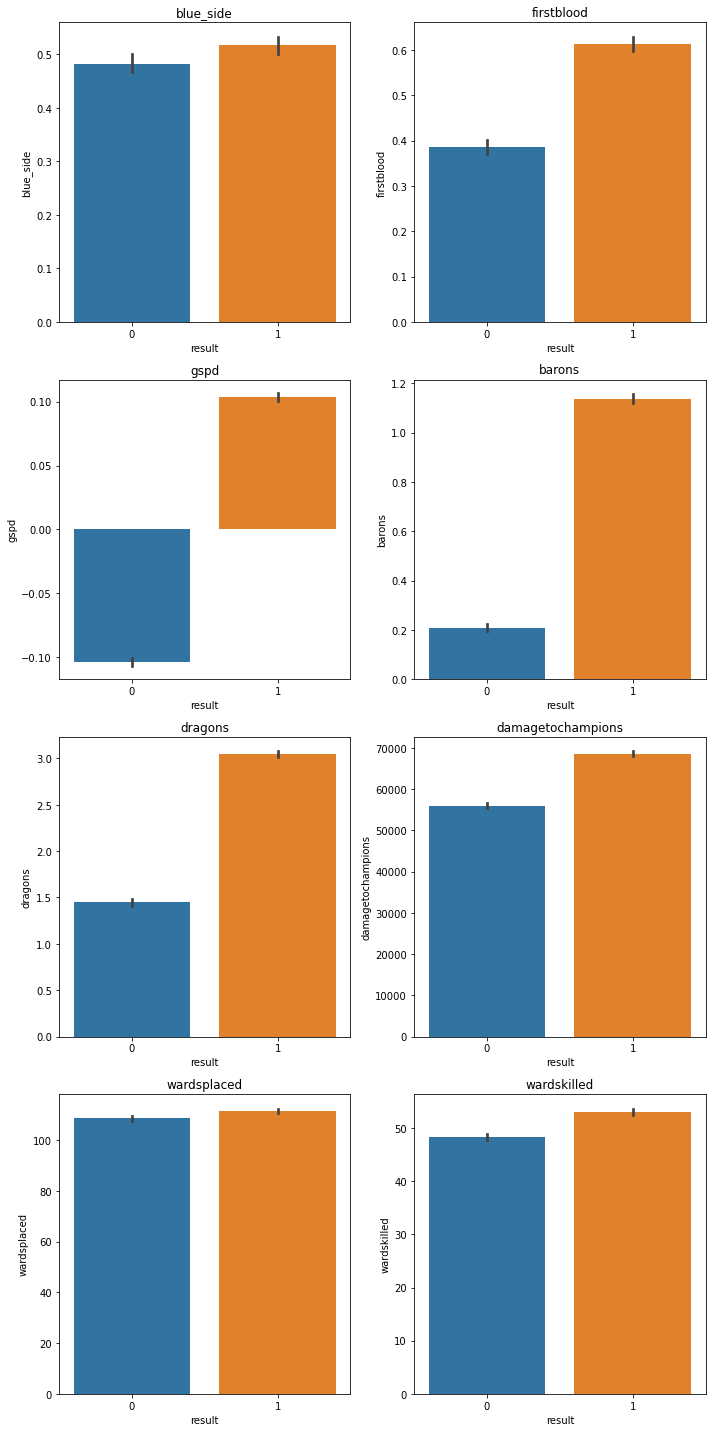

In [4]:
v.plot_cols(train) #create plots

### All variables are statistically signficant except for 'blue_side' and 'firstblood'

In [5]:
v.get_tstat(train) #run ttest on 8 columns

,column,t_stat,p_value
0,blue_side,0.000000,1.00
1,firstblood,-0.048202,0.96
2,gspd,-84.849879,0.00
3,barons,17.426989,0.00
4,dragons,104.611756,0.00
5,damagetochampions,258.147354,0.00
6,wardsplaced,319.867756,0.00
7,wardskilled,244.285662,0.00


### Exploration Summary

It looks like 'blue_side' doesn't have too much of an impact on 'result'. This is surprising because in a sense it's like being the 'home' team. Blue side has easier access to the baron pit, and we can see from above that getting baron is very important to winning.  

Wardsplaced are very consistent between the winning and losing teams, but the winning team has higher wardskilled. This reduces the enemy's vision, increasing the odds of making successful plays.

The most important variable might be 'gspd' which is 'gold spent percentage differential' - gold makes each champion more powerful, and the more powerful they become the higher chance to win. Many of these variables either directly or indirectly.

### Feature Engineering
    -Add next opponent
    -Add date of next match
    -Add side (blue or red) for next game
    -Add rolling 10 game average for team stats

In [6]:
df = w.add_target(df) #add 'target' col
df = w.add_opp_name(df) #add 'opp_name'

removed_columns = ['teamname','league','date','target','opp_name']
selected_columns = df.columns[~df.columns.isin(removed_columns)]

scaler = MinMaxScaler() #scale numerical data
df[selected_columns] = scaler.fit_transform(df[selected_columns])

df = w.add_rolling(df) #create rolling averages, next opp, next side, next date
df = w.add_opp(df)
df = w.add_next_side(df)
df = w.add_next_date(df)

In [7]:
rolling_cols = ['gamelength','teamkills','teamdeaths','firstblood','dragons','barons','opp_barons','towers','opp_towers',\
       'inhibitors','opp_inhibitors','damagetochampions','damagetakenperminute','wardsplaced','wardskilled',\
       'controlwardsbought','totalgold','gspd']

full = df.merge(df[rolling_cols + ["next_opp", "next_date", "teamname"]], left_on=["teamname", "next_date"], \
                right_on=["next_opp", "next_date"]) #merge next opponent data onto current game

### Establish a Baseline:
    -Teams on blue side win ~52% of the time, establishing our baseline

In [8]:
#Establish baseline
len(df[(df.blue_side==1) & (df.result == 1)])/(df.shape[0]/2) #Establishes a baseline - blue team wins 52% of time

0.5188270293242669

### Used Sequential Feature Selection  to pick 14 best features to include in model 


In [9]:
rr = RidgeClassifier(solver ='sag',normalize=False,) #Use sfs to determine 14 best columns for model
split = TimeSeriesSplit(n_splits=3)
sfs = SequentialFeatureSelector(rr, n_features_to_select=14,direction='forward',cv=split,n_jobs=-1)

In [10]:
removed_columns = list(full.columns[full.dtypes=='object']) + removed_columns
selected_columns = full.columns[~full.columns.isin(removed_columns)]

splits = m.near_split(df.shape[0],5)
last_split = splits[-1]-splits[-2] #Difference between last two values for final 'test' set

### Run Models
    -Used GridSearchCV to find the best hyperparameters for a Ridge Regression
        -Examined 14 possible combinations and selected the best one

In [11]:
sfs.fit(full[selected_columns],full['target']) #Run model and get accuracy score
selectors = selected_columns[sfs.get_support()]
predictions = m.backtest(full,rr,selectors,'target',splits,last_split)
accuracy_score(predictions.actual,predictions.prediction)

0.5919142282778647

In [12]:
selectors #View the selectors from the model

Index(['gamelength_x', 'teamkills_x', 'dragons_x', 'opp_inhibitors_x',
       'wardskilled_x', 'controlwardsbought_x', 'opp_barons_rolling',
       'towers_rolling', 'opp_inhibitors_rolling', 'wardskilled_rolling',
       'teamkills_y', 'firstblood_y', 'opp_towers_y', 'gspd_y'],
      dtype='object')

### Used a Backtest to determine the accuracy of our predictions 
    - 59.4% accuracy beating the baseline of 52% by 7.4%! 

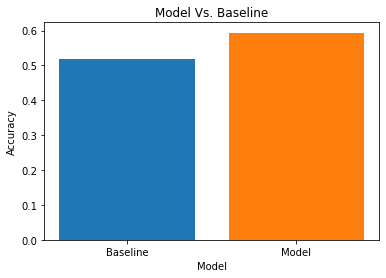

In [13]:
v.plot_model() #plot difference between model and baseline

### Recommendations:
- Teams that kill baron win more
- Teams that spend more gold win more
    -In order to spend gold you have to make gold (killing minions, opponents, and turrets)

### Conclusion:
    -This model beats the baseline by a substantial amount with more room for improvement
    -It is unclear whether it is possible to use this model to make a million dollars

### Next Steps:
    -Add champion selection data
    -Use model to predict upcoming games
    -Add tier 2 leagues
    -Determine where model has the edge over betting markets